In [1]:
%load_ext autoreload
%autoreload 2

In [144]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import regionate
import matplotlib.pyplot as plt

## 0. Loading and exploring CM4 ocean diagnostics

In [145]:
from example_dataset_grids import load_OM4p5
ds, grid = load_OM4p5("sigma2", z_coord="natv")

## 1. Determine a mask for the region of interest.

In [146]:
import pickle
BasinsFile = "/work/hfd/datasets/regionate/pickled_regions/PJ2010_region_gridded_OM4p5"
with open(BasinsFile, 'rb') as pickle_file:
    regions = pickle.load(pickle_file).regions

In [147]:
region = regions['24']
ds['mask'] = region.mask

/vftmp/Henri.Drake/pid37316/ipykernel_26804/3776872106.py:9: UserWarning: No contour levels were found within the data range.
  plt.contour(
/vftmp/Henri.Drake/pid37316/ipykernel_26804/3776872106.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(


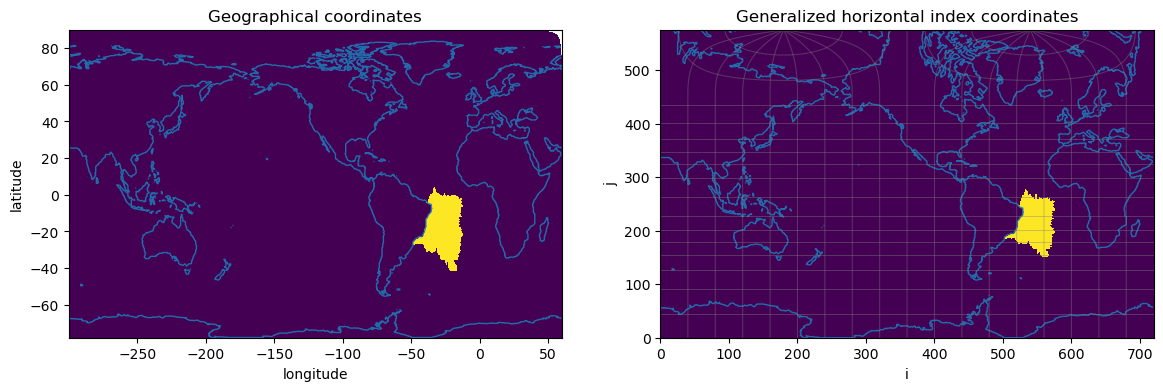

In [148]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    ds.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1,2,2)
plt.pcolor(
    ds.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");

In [149]:
import yaml

with open("../conventions/MOM6.yaml", "r") as stream:
    try:
        budgets_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [150]:
import xwmb
wmb = xwmb.WaterMassBudget(
    grid,
    budgets_dict,
    region
)
toSv = 1.e-6/wmb.rho_ref

In [152]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmt = wmb.mass_budget("heat")

## 5. We load the key integrated water mass budget terms into memory and plot them

In [153]:
# Water Mass Transformation terms
%time wmt['tendency'].load()
%time wmt['advection'].load()
%time wmt['diffusion'].load()
%time wmt['external_forcing'].load()

# Overturning in density space
%time wmt['overturning'].load()
%time wmt['mass_source'].load()
%time wmt['residual_mass_tendency'].load()

# Density layer mass tendency
%time wmt['mass_tendency'].load()

# Isolate numerical errors from advection/tendency terms
wmt['numerical_errors'].load();

CPU times: user 23.8 s, sys: 5.37 s, total: 29.1 s
Wall time: 28.8 s
CPU times: user 47.4 s, sys: 9.95 s, total: 57.4 s
Wall time: 29.8 s
CPU times: user 47.1 s, sys: 9.51 s, total: 56.6 s
Wall time: 29.4 s
CPU times: user 1min 11s, sys: 13.7 s, total: 1min 24s
Wall time: 30.7 s
CPU times: user 715 ms, sys: 977 ms, total: 1.69 s
Wall time: 1.47 s
CPU times: user 24.7 s, sys: 5.99 s, total: 30.7 s
Wall time: 30.2 s
CPU times: user 24.6 s, sys: 5.96 s, total: 30.5 s
Wall time: 30.1 s
CPU times: user 1min 8s, sys: 48.9 s, total: 1min 57s
Wall time: 1min 16s


In [154]:
wmt[[
    'tendency',
    'advection',
    'diffusion',
    'external_forcing',
    'overturning',
    'mass_source',
    'residual_mass_tendency',
    'mass_tendency',
    'numerical_errors'
]].to_netcdf("/work/hfd/codedev/xwmb/data/budget_BrazilBasin.nc", mode="w")

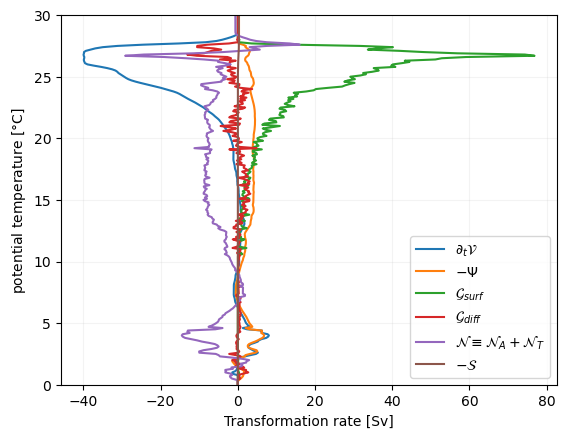

In [155]:
(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", y="thetao_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", y="thetao_l")
(wmt['external_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", y="thetao_l")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", y="thetao_l")
(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", y="thetao_l")
(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", y="thetao_l")
plt.legend()
plt.grid(True, alpha=0.15)
plt.ylim(0, 30)
plt.xlabel("Transformation rate [Sv]")
plt.ylabel(r"potential temperature [$\degree$C]");

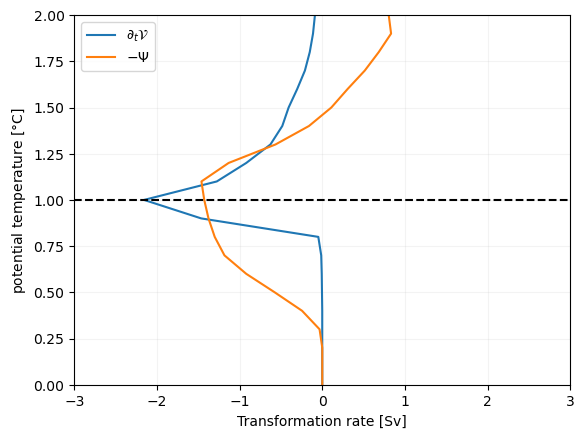

In [136]:
(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", y="thetao_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", y="thetao_l")
#(wmt['external_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", y="thetao_l")
#(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", y="thetao_l")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", y="thetao_l")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", y="thetao_l")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.15)
plt.ylim(0, 2)
plt.xlim(-3, 3)
plt.xlabel("Transformation rate [Sv]")
plt.ylabel(r"potential temperature [$\degree$C]");
plt.axhline(1., ls="--", color="k")

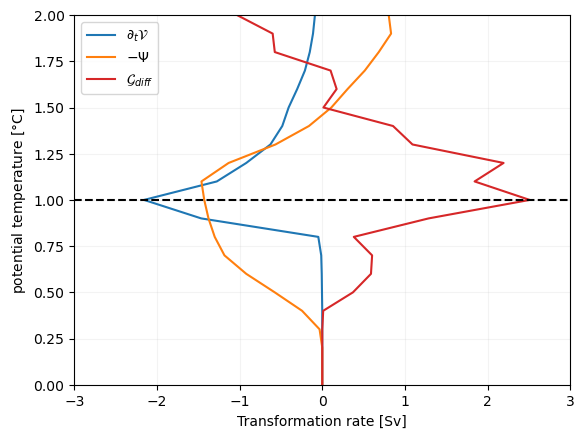

In [142]:
(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", y="thetao_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", y="thetao_l")
#(wmt['external_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2", y="thetao_l")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", y="thetao_l", color="C3")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", y="thetao_l")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", y="thetao_l")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.15)
plt.ylim(0, 2)
plt.xlim(-3, 3)
plt.xlabel("Transformation rate [Sv]")
plt.ylabel(r"potential temperature [$\degree$C]");
plt.axhline(1., ls="--", color="k")

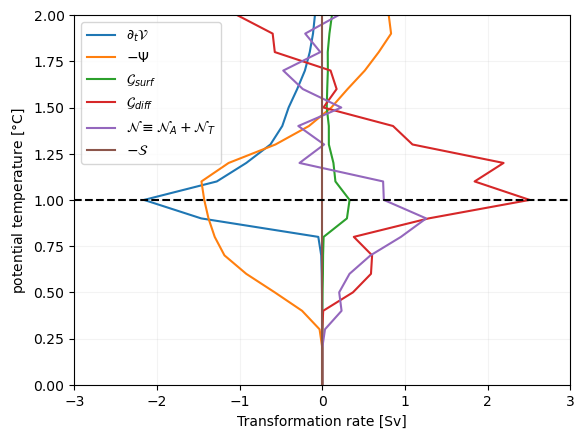

In [132]:
(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", y="thetao_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", y="thetao_l")
(wmt['external_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", y="thetao_l")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", y="thetao_l")
(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", y="thetao_l")
(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", y="thetao_l")
plt.legend()
plt.grid(True, alpha=0.15)
plt.ylim(0, 2)
plt.xlim(-3, 3)
plt.xlabel("Transformation rate [Sv]")
plt.ylabel(r"potential temperature [$\degree$C]");
plt.axhline(1., ls="--", color="k")

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

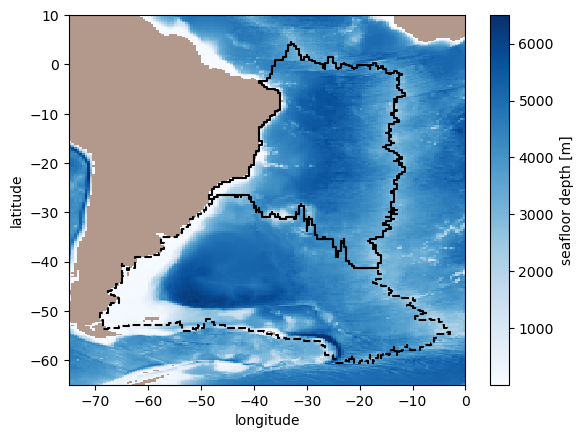

In [114]:
fig, ax = plt.subplots(1, 1)

wmb.ds['deptho'] = wmb.ds['deptho'].where(wmb.ds['deptho']!=0.)
dep_cmap = plt.get_cmap('Blues').copy()
dep_cmap.set_bad((0.7, 0.6, 0.55))
pc = plt.pcolormesh(wmb.ds['geolon_c'], wmb.ds['geolat_c'], wmb.ds['deptho'], cmap=dep_cmap)
plt.colorbar(pc, label="seafloor depth [m]")

plt.plot(regions['23'].lons, regions['23'].lats, "k--")
plt.plot(regions['24'].lons, regions['24'].lats, "k-")

plt.xlim(-75, -0)
plt.ylim(-65, 10)
plt.xlabel("longitude")
plt.ylabel("latitude");

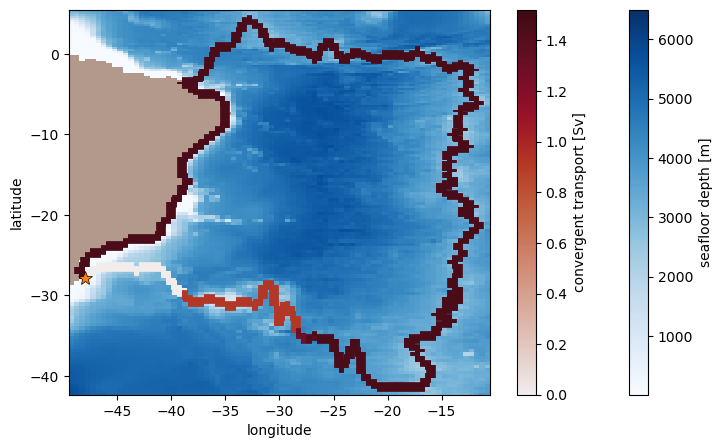

In [118]:
Ti = 1.1

fig, ax = plt.subplots(1, 1, figsize=(8.5, 5))

wmb.ds['deptho'] = wmb.ds['deptho'].where(wmb.ds['deptho']!=0.)
dep_cmap = plt.get_cmap('Blues').copy()
dep_cmap.set_bad((0.7, 0.6, 0.55))
pc = plt.pcolormesh(wmb.ds['geolon_c'], wmb.ds['geolat_c'], wmb.ds['deptho'], cmap=dep_cmap)
plt.colorbar(pc, label="seafloor depth [m]")

x = region.lons
y = region.lats

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
Ψmax = np.abs(transport.sel(thetao_i=Ti, method="nearest").cumsum('sect')).max()/wmb.rho_ref*1e-6 * 1.05
norm = plt.Normalize(0, Ψmax)
lc = LineCollection(segments, cmap=cm.cm.amp, norm=norm)

# Set the values used for colormapping
lc.set_array(-transport.sel(thetao_i=Ti, method="nearest").cumsum('sect')/wmb.rho_ref*1e-6)
lc.set_linewidth(7)
lc.set_alpha(1.)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label="convergent transport [Sv]")

plt.plot([region.lons[0]], [region.lats[0]], "C1*", markersize=10, markeredgecolor="k", markeredgewidth=0.5)
ax.set_xlim(x.min()-1, x.max()+1)
ax.set_ylim(y.min()-1, y.max()+1)
plt.xlabel("longitude")
plt.ylabel("latitude");

In [76]:
transport = wmb.ds['convergent_mass_transport_below'].mean('time').compute()

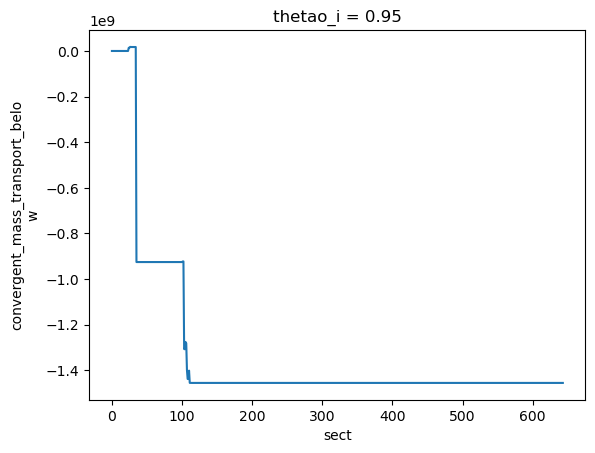

In [86]:
transport.sel(thetao_i=1.0, method="nearest").cumsum("sect").plot()

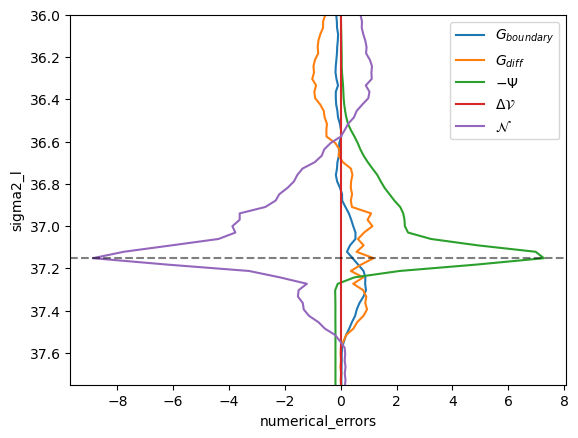

In [81]:
(wmt['external_forcing']*toSv).mean('time').plot(label=r"$G_{boundary}$", y="sigma2_l")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$G_{diff}$", y="sigma2_l")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", y="sigma2_l")
(wmt['mass_tendency_below']*toSv).mean('time').plot(label=r"$\Delta \mathcal{V}$", y="sigma2_l")
(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}$", y="sigma2_l")

sigma2_max_overturning = wmt['overturning'].mean('time').idxmax()
plt.axhline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)

plt.ylim(37.75, 36)
plt.legend()

## 6. We decompose the transport term spatially to understand where key outflows are dense shelf water are

In [ ]:
wmb.ds['convergent_mass_transport_below'].load();

In [ ]:
outflows = wmb.ds['convergent_mass_transport_below'].sel(sigma2_i=sigma2_max_overturning, method="nearest").cumsum("sect")*toSv
outflows = outflows.where((outflows!=0.) & (outflows!=outflows.isel(sect=-1)), np.nan)

plt.figure(figsize=(12, 4.5))
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=-2, vmax=2,
    cmap="Greys"
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="k",
    linewidths=1.,
    alpha=0.9
)
sc = plt.scatter(
    wmb.region.lons,
    wmb.region.lats,
    c=outflows,
    cmap="RdBu_r"
)
plt.colorbar(sc, label="cumulative export along boundary [Sv]")
plt.title("Along-boundary structure of dense shelf water export")
plt.clim(-5., 5.)
plt.xlim(-300, 60)
plt.ylim(-79, -59);